In [3]:
import numpy as np
from tic_env import TictactoeEnv, OptimalPlayer
import random
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [31]:
list_of_action = {
    0: (0,0),
    1: (0,1),
    2: (0,2),
    3: (1,0),
    4: (1,1),
    5: (1,2),
    6: (2,0),
    7: (2,1),
    8: (2,2)
}

rev_action = {
    (0,0) :0,
    (0,1) :1,
    (0,2) :2,
    (1,0) :3,
    (1,1) :4,
    (1,2) :5,
    (2,0) :6,
    (2,1) :7,
    (2,2) :8
}

In [43]:
def make_state_for_input(obs_env):
    output = np.zeros((3,3,2))
    for i in range(3):
        for j in range(3):
            if obs_env[i,j] == 1:
                #print(list_of_action[i],"1")
                output[i,j,0] = 1
            elif obs_env[i,j] == -1:
                #print(list_of_action[i],"-1")
                output[i,j,1] = 1
    return output


check_state = np.array([[1,0,-1],[0,0,1],[0,-1,0]])
make_state_for_input(check_state).shape, make_state_for_input(check_state)[:,:,0], make_state_for_input(check_state)[:,:,1]

((3, 3, 2),
 array([[1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 0.]]),
 array([[0., 0., 1.],
        [0., 0., 0.],
        [0., 1., 0.]]))

In [193]:
BATCH_SIZE = 64
GAMMA = 0.99
BUFFER_SIZE = 10000
MIN_REPLAY_SIZE = 40
#EPS_START = 0.9
#EPS_END = 0.05
#EPS_DECAY = 200
TARGET_UPDATE_FREQ = 500



class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        in_features = int(3*3*2)
        
        self.net = nn.Sequential(
            nn.Linear(in_features,128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,9)
        )

    def forward(self,x):
        return self.net((x.view(x.size(0), -1)))

    def act(self,obs):
        obs_t = torch.as_tensor(obs, dtype=torch.float32)
        q_values = self(obs_t.unsqueeze(0))

        max_q_index = torch.argmax(q_values,dim=1)[0]
        action = max_q_index.detach().item()
        return action


env = TictactoeEnv()

replay_buffer = deque(maxlen=BUFFER_SIZE)
rew_buffer = deque([0.], maxlen=100) #MAYBE 10 is better

episode_reward = 0.


policy_net = Network() #.to("cpu")
target_net = Network() #.to("cpu")
target_net.load_state_dict(policy_net.state_dict())

optimizer = torch.optim.Adam(policy_net.parameters(), lr=5e-4)

In [133]:
target_net.parameters

<bound method Module.parameters of Network(
  (net): Sequential(
    (0): Linear(in_features=18, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=9, bias=True)
  )
)>

In [194]:
def number_wins(eps):    
      N_win = 0
      N_wino = 0
      draw = 0
      for games in range(500):

            env.reset()
            if games%2 == 0:
                  opt_player = OptimalPlayer(epsilon = eps, player = 'O')

            if games%2 == 1:
                  opt_player = OptimalPlayer(epsilon = eps, player = 'X')
                  grid, _, __ = env.observe()
                  comp_move = opt_player.act(grid)
                  env.step(comp_move)
      
            for rounds in range(5):
                  state_now = env.observe()[0]
                  best_action1 = policy_net.act(make_state_for_input(state_now))

                  if state_now[list_of_action[best_action1]] != 0:
                        N_wino = N_wino+1
                        break
        
                  #make the move with that best action
                  env.step(best_action1)
                  #env.render()
                  #Now the computer plays (for a fair game ahaha)
                  grid, _, __ = env.observe()
        
                  if env.observe()[1] == True:
                        if str(env.winner) == 'X' and games%2 == 0:
                              N_win = N_win+1
                        elif str(env.winner) == 'O' and games%2 == 0:
                              N_wino = N_wino+1
                        elif str(env.winner) == 'O' and games%2 == 1:
                              N_win = N_win+1
                        elif str(env.winner) == 'X' and games%2 == 1:
                              N_wino = N_wino+1
                        else:
                              draw = draw+1
                        break
        
                  comp_move = opt_player.act(grid)
                  env.step(comp_move)

                  if env.observe()[1] == True:
                        if str(env.winner) == 'X' and games%2 == 0:
                              N_win = N_win+1
                        elif str(env.winner) == 'O' and games%2 == 0:
                              N_wino = N_wino+1
                        elif str(env.winner) == 'O' and games%2 == 1:
                              N_win = N_win+1
                        elif str(env.winner) == 'X' and games%2 == 1:
                              N_wino = N_wino+1
                        else:
                              draw = draw+1
                        break

      return N_win, N_wino


In [140]:
replay_buffer

deque([])

In [52]:
obs = env.reset()

env.step(1)[0][(1,2)]
list_of_action[3]

(1, 0)

In [195]:
env.reset()

state_zero = env.observe()[0]

for games in range(300):
    env.reset()

    if games%2 == 0:
        player1 = "X"
        player2 = "O"
        opt_player = OptimalPlayer(epsilon = 0.5, player = player2)
    if games%2 == 1:
        player1 = "O"
        player2 = "X"
        #change the state by *-1 when best player is X
        opt_player = OptimalPlayer(epsilon = 0.5, player = player2)
        grid, _, __ = env.observe()
        comp_move = opt_player.act(grid)
        env.step(comp_move)


    for rounds in range(5):

        #I play
        state_now = env.observe()[0]
        #selecting the best action considering the present state
        best_action1 = np.random.randint(0,9)
        
        ###If you can not take the action??
        if state_now[list_of_action[best_action1]] != 0:
            end = True
            rew = -1
            transition = (state_now, best_action1, rew, end, state_zero)
            replay_buffer.append(transition)
            episode_reward += rew
            rew_buffer.append(episode_reward)
            episode_reward = 0.
            break

        #make the move with that best action
        env.step(best_action1)

        #Now the computer plays (for a fair game ahaha)
        grid, _, __ = env.observe()
        
        if env.observe()[1] == True:
            rew = env.reward(player=player1)
            transition = (state_now, best_action1, rew, env.observe()[1], env.observe()[0])
            replay_buffer.append(transition)
            episode_reward += rew
            rew_buffer.append(episode_reward)
            episode_reward = 0.
            break
        
        
        comp_now = env.observe()[0]
        comp_move = opt_player.act(grid)
        env.step(comp_move)

        if env.observe()[1] == True:
            rew = env.reward(player=player1)
            transition = (state_now, best_action1, rew, env.observe()[1], env.observe()[0])
            replay_buffer.append(transition)
            episode_reward += rew
            rew_buffer.append(episode_reward)
            episode_reward = 0.
            break

        #Gather information about the state the game is in after the computer played
        future_state = env.observe()[0]
        
        _, end, winner = env.observe()
        rew = env.reward(player=player1)                    ##HAVE TO CHANGE ACCORDING TO THE PLAYER
        transition = (state_now, best_action1, rew, end, future_state)
        replay_buffer.append(transition)
        episode_reward += rew
        


In [59]:
policy_net.act(make_state_for_input(env.reset()[0]))

2

In [196]:
##############MAIN TRAINING LOOP
#opt_player = OptimalPlayer(epsilon = 0.5, player = 'O')
M_opt = []
M_rand = []
average_reward = []
average_loss = []
current_average_reward = 0
current_training_loss = 0
env.reset()
obs = env.observe()[0]
zero_state = env.observe()[0]
step = 0
epsilon = 0.3
for games in range(20000):
    step += 1
    env.reset()
    epsilon = 0.
    obs = env.observe()[0]
    action = policy_net.act(make_state_for_input(obs))


    if games%2 == 0:
        player1 = "X"
        player2 = "O"
        opt_player = OptimalPlayer(epsilon = 0.5, player = player2)
    if games%2 == 1:
        player1 = "O"
        player2 = "X"
        #change the state by *-1 when best player is X
        opt_player = OptimalPlayer(epsilon = 0.5, player = player2)
        grid, _, __ = env.observe()
        comp_move = opt_player.act(grid)
        env.step(comp_move)

    if games%250 == 0:
        average_reward.append(current_average_reward/250)
        current_average_reward = 0
        print()
        print(current_training_loss/250)
        average_loss.append(current_training_loss/250)
        current_training_loss = 0



    for rounds in range(5):
        step += 1
        #I play
        state_now = env.observe()[0]
        #selecting the best action considering the present state
        if epsilon == 0.:
            best_action1 = policy_net.act(make_state_for_input(state_now))
        else:
            random_number = np.random.randint(0,10)
            if random_number >= epsilon*10:
                best_action1 = policy_net.act(make_state_for_input(state_now))
            else:
                best_action1 = random_number
        #best_action1 = policy_net.act(make_state_for_input(state_now))
        
        ###If you can not take the action??
        if state_now[list_of_action[best_action1]] != 0:
            end = True
            rew = -1
            current_average_reward += -1
            transition = (state_now, best_action1, rew, end, zero_state)
            replay_buffer.append(transition)
            episode_reward += rew
            rew_buffer.append(episode_reward)
            episode_reward = 0.
            break

        #make the move with that best action
        env.step(best_action1)

        #Now the computer plays (for a fair game ahaha)
        grid, _, __ = env.observe()
        
        if env.observe()[1] == True:
            rew = env.reward(player=player1)
            current_average_reward += rew
            transition = (state_now, best_action1, rew, env.observe()[1], env.observe()[0])
            replay_buffer.append(transition)
            episode_reward += rew
            rew_buffer.append(episode_reward)
            episode_reward = 0.
            break
        
        step += 1
        comp_now = env.observe()[0]
        comp_move = opt_player.act(grid)
        env.step(comp_move)

        if env.observe()[1] == True:
            rew = env.reward(player=player1)
            current_average_reward += rew
            transition = (state_now, best_action1, rew, env.observe()[1], env.observe()[0])
            replay_buffer.append(transition)
            episode_reward += rew
            rew_buffer.append(episode_reward)
            episode_reward = 0.
            break

        #Gather information about the state the game is in after the computer played
        future_state = env.observe()[0]
        
        _, end, winner = env.observe()
        rew = env.reward(player=player1)                    ##HAVE TO CHANGE ACCORDING TO THE PLAYER
        transition = (state_now, best_action1, rew, end, future_state)
        replay_buffer.append(transition)
        episode_reward += rew
        




    ##START GRADIENT STEP
    transitions = random.sample(replay_buffer, BATCH_SIZE)

    obses = np.asarray([make_state_for_input(t[0]) for t in transitions])
    actions = np.asarray([t[1] for t in transitions])
    rew = np.asarray([t[2] for t in transitions])
    dones = np.asarray([t[3] for t in transitions])
    new_obses = np.asarray([make_state_for_input(t[4]) for t in transitions])

    obses_t = torch.as_tensor(obses, dtype=torch.float32)
    actions_t = torch.as_tensor(actions, dtype=torch.int64).unsqueeze(-1)
    rews_t = torch.as_tensor(rew, dtype=torch.float32).unsqueeze(-1)
    dones_t = torch.as_tensor(dones, dtype=torch.float32).unsqueeze(-1)
    new_obses_t = torch.as_tensor(new_obses, dtype=torch.float32)

    target_q_values = target_net(new_obses_t)
    
    max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
    
    targets = rews_t + GAMMA * (1 - dones_t) * max_target_q_values


    ###COMPUTE LOSS
    q_values = policy_net(obses_t)
    #q_values_max = q_values.max(dim=1, keepdim=True)[0]
    #print(actions_t.shape, q_values.shape)
    action_q_values = torch.gather(input=q_values, dim=1, index=actions_t)

    loss = nn.functional.smooth_l1_loss(action_q_values, targets)
    current_training_loss += loss.item()

    ####GRADIENT STEP
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ####UPDATE TARGET NETWORK
    if games % TARGET_UPDATE_FREQ == 0:
        target_net.load_state_dict(policy_net.state_dict())

    if games % 500 == 0:
        print()
        print("game",games)
        print("Avg_rew", np.mean(rew_buffer))
        print("Loss", loss)
        N_me, N_comp = number_wins(0.)
        print("M_opt",N_me,N_comp)
        M_opt.append((N_me-N_comp)/500)
        N_me, N_comp = number_wins(1.)
        print("M_rand",N_me,N_comp)
        M_rand.append((N_me-N_comp)/500)
        



0.0

game 0
Avg_rew -0.94
Loss tensor(0.1857, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 500
M_rand 0 500

0.08401154626905918

0.05592607942968607

game 500
Avg_rew -0.43
Loss tensor(0.0499, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 500
M_rand 282 166

0.054647793389856814

0.051214788176119325

game 1000
Avg_rew -0.16
Loss tensor(0.0526, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 369
M_rand 310 108

0.05906493644416332

0.053771414004266264

game 1500
Avg_rew 0.01
Loss tensor(0.0589, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 92
M_rand 314 62

0.06385180258750915

0.06282927667349578

game 2000
Avg_rew 0.09
Loss tensor(0.0628, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 250
M_rand 372 70

0.06451925633847713

0.06173103923350572

game 2500
Avg_rew 0.23
Loss tensor(0.0825, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 203
M_rand 398 43

0.06397559176385402

0.0606743690147996

game 3000
Avg_rew 0.49
Loss tensor(0.0700, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 166
M_rand 426 29

0.06195304243266583


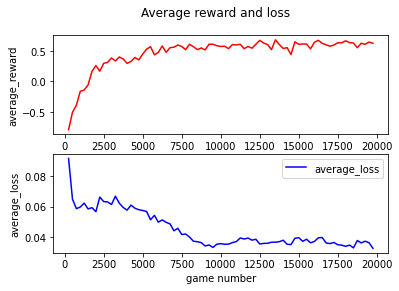

In [145]:
game_number = []
for i in range(80):
    game_number.append(250*i)
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Average reward and loss')
ax1.plot(game_number[1:],average_reward[1:],color='r',label='average_reward')
ax2.plot(game_number[1:],average_loss[1:], color="b",label="average_loss")

ax1.set(xlabel='game_number', ylabel='average_reward')
ax2.set(xlabel='game_number', ylabel='average_loss')

plt.xlabel("game number")
plt.legend()
plt.savefig('Ques11.png')
plt.savefig('Ques11.pdf')
plt.show()

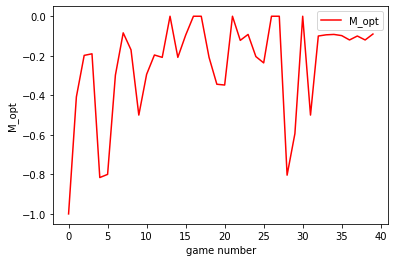

In [146]:

plt.plot(M_opt,color='r',label='M_opt')
plt.ylabel("M_opt")
plt.xlabel("game number")
plt.legend()
plt.show()

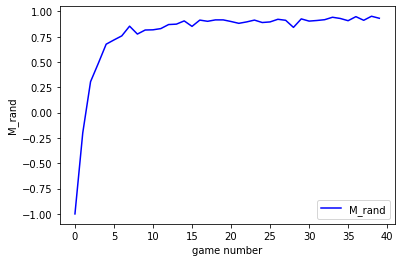

In [147]:
plt.plot(M_rand,color='b',label='M_rand')
plt.ylabel("M_rand")
plt.xlabel("game number")
plt.legend()
plt.show()

In [148]:
number_wins(0.)

(0, 59)

In [149]:
number_wins(1.)

(474, 5)

# Question 12

In [178]:
BATCH_SIZE = 1
GAMMA = 0.99
BUFFER_SIZE = 10000
MIN_REPLAY_SIZE = 40
#EPS_START = 0.9
#EPS_END = 0.05
#EPS_DECAY = 200
TARGET_UPDATE_FREQ = 500



class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        in_features = int(3*3*2)
        
        self.net = nn.Sequential(
            nn.Linear(in_features,128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,9)
        )

    def forward(self,x):
        return self.net((x.view(x.size(0), -1)))

    def act(self,obs):
        obs_t = torch.as_tensor(obs, dtype=torch.float32)
        q_values = self(obs_t.unsqueeze(0))

        max_q_index = torch.argmax(q_values,dim=1)[0]
        action = max_q_index.detach().item()
        return action


env = TictactoeEnv()

replay_buffer = deque(maxlen=BUFFER_SIZE)
rew_buffer = deque([0.], maxlen=100) #MAYBE 10 is better

episode_reward = 0.


policy_net = Network() #.to("cpu")
target_net = Network() #.to("cpu")
target_net.load_state_dict(policy_net.state_dict())

optimizer = torch.optim.Adam(policy_net.parameters(), lr=5e-4)

In [179]:
##############MAIN TRAINING LOOP
#opt_player = OptimalPlayer(epsilon = 0.5, player = 'O')
M_opt = []
M_rand = []
average_reward = []
average_loss = []
current_average_reward = 0
current_training_loss = 0
env.reset()
obs = env.observe()[0]
zero_state = env.observe()[0]
step = 0
epsilon = 0.3
for games in range(20000):
    
    env.reset()
    epsilon = 0.
    obs = env.observe()[0]
    action = policy_net.act(make_state_for_input(obs))


    if games%2 == 0:
        player1 = "X"
        player2 = "O"
        opt_player = OptimalPlayer(epsilon = 0.5, player = player2)
    if games%2 == 1:
        player1 = "O"
        player2 = "X"
        #change the state by *-1 when best player is X
        opt_player = OptimalPlayer(epsilon = 0.5, player = player2)
        grid, _, __ = env.observe()
        comp_move = opt_player.act(grid)
        env.step(comp_move)

    if games%250 == 0:
        average_reward.append(current_average_reward/250)
        current_average_reward = 0
        print()
        print(current_training_loss/250)
        average_loss.append(current_training_loss/250)
        current_training_loss = 0



    for rounds in range(5):
        step += 1
        #I play
        state_now = env.observe()[0]
        #selecting the best action considering the present state
        if epsilon == 0.:
            best_action1 = policy_net.act(make_state_for_input(state_now))
        else:
            random_number = np.random.randint(0,10)
            if random_number >= epsilon*10:
                best_action1 = policy_net.act(make_state_for_input(state_now))
            else:
                best_action1 = random_number
        #best_action1 = policy_net.act(make_state_for_input(state_now))
        
        ###If you can not take the action??
        if state_now[list_of_action[best_action1]] != 0:
            end = True
            rew = -1
            current_average_reward += -1
            transition = (state_now, best_action1, rew, end, zero_state)
            #replay_buffer.append(transition)
            episode_reward += rew
            rew_buffer.append(episode_reward)
            episode_reward = 0.
            
            obses = np.asarray(make_state_for_input(transition[0]))
            actions = np.asarray(transition[1])
            rew = np.asarray(transition[2])
            dones = np.asarray(transition[3])
            new_obses = np.asarray(make_state_for_input(transition[4]))

            obses_t = torch.as_tensor(obses, dtype=torch.float32)
            actions_t = torch.as_tensor(actions, dtype=torch.int64).unsqueeze(-1)
            rews_t = torch.as_tensor(rew, dtype=torch.float32).unsqueeze(-1)
            dones_t = torch.as_tensor(dones, dtype=torch.float32).unsqueeze(-1)
            new_obses_t = torch.as_tensor(new_obses, dtype=torch.float32)
            
            target_q_values = target_net(new_obses_t[None,:,:,:])
            max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
            targets = rews_t + GAMMA * (1 - dones_t) * max_target_q_values
            ###COMPUTE LOSS
            q_values = policy_net(obses_t[None,:,:,:])
            action_q_values =  q_values[:,actions_t]       #torch.gather(input=q_values, dim=1, index=actions_t)

            loss = nn.functional.smooth_l1_loss(action_q_values, targets)
            current_training_loss += loss.item()

            ####GRADIENT STEP
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            break

        #make the move with that best action
        env.step(best_action1)

        #Now the computer plays (for a fair game ahaha)
        grid, _, __ = env.observe()
        
        if env.observe()[1] == True:
            rew = env.reward(player=player1)
            current_average_reward += rew
            transition = (state_now, best_action1, rew, env.observe()[1], env.observe()[0])
            #replay_buffer.append(transition)
            episode_reward += rew
            rew_buffer.append(episode_reward)
            episode_reward = 0.

            obses = np.asarray(make_state_for_input(transition[0]))
            actions = np.asarray(transition[1])
            rew = np.asarray(transition[2])
            dones = np.asarray(transition[3])
            new_obses = np.asarray(make_state_for_input(transition[4]))

            obses_t = torch.as_tensor(obses, dtype=torch.float32)
            actions_t = torch.as_tensor(actions, dtype=torch.int64).unsqueeze(-1)
            rews_t = torch.as_tensor(rew, dtype=torch.float32).unsqueeze(-1)
            dones_t = torch.as_tensor(dones, dtype=torch.float32).unsqueeze(-1)
            new_obses_t = torch.as_tensor(new_obses, dtype=torch.float32)
            
            target_q_values = target_net(new_obses_t[None,:,:,:])
            max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
            targets = rews_t + GAMMA * (1 - dones_t) * max_target_q_values
            ###COMPUTE LOSS
            q_values = policy_net(obses_t[None,:,:,:])
            action_q_values =  q_values[:,actions_t]       #torch.gather(input=q_values, dim=1, index=actions_t)

            loss = nn.functional.smooth_l1_loss(action_q_values, targets)
            current_training_loss += loss.item()

            ####GRADIENT STEP
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            break
        
        step += 1
        comp_now = env.observe()[0]
        comp_move = opt_player.act(grid)
        env.step(comp_move)

        if env.observe()[1] == True:
            rew = env.reward(player=player1)
            current_average_reward += rew
            transition = (state_now, best_action1, rew, env.observe()[1], env.observe()[0])
            #replay_buffer.append(transition)
            episode_reward += rew
            rew_buffer.append(episode_reward)
            episode_reward = 0.


            obses = np.asarray(make_state_for_input(transition[0]))
            actions = np.asarray(transition[1])
            rew = np.asarray(transition[2])
            dones = np.asarray(transition[3])
            new_obses = np.asarray(make_state_for_input(transition[4]))

            obses_t = torch.as_tensor(obses, dtype=torch.float32)
            actions_t = torch.as_tensor(actions, dtype=torch.int64).unsqueeze(-1)
            rews_t = torch.as_tensor(rew, dtype=torch.float32).unsqueeze(-1)
            dones_t = torch.as_tensor(dones, dtype=torch.float32).unsqueeze(-1)
            new_obses_t = torch.as_tensor(new_obses, dtype=torch.float32)
            
            target_q_values = target_net(new_obses_t[None,:,:,:])
            max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
            targets = rews_t + GAMMA * (1 - dones_t) * max_target_q_values
            ###COMPUTE LOSS
            q_values = policy_net(obses_t[None,:,:,:])
            action_q_values =  q_values[:,actions_t]       #torch.gather(input=q_values, dim=1, index=actions_t)

            loss = nn.functional.smooth_l1_loss(action_q_values, targets)
            current_training_loss += loss.item()

            ####GRADIENT STEP
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            break

        #Gather information about the state the game is in after the computer played
        future_state = env.observe()[0]
        
        _, end, winner = env.observe()
        rew = env.reward(player=player1)                    ##HAVE TO CHANGE ACCORDING TO THE PLAYER
        transition = (state_now, best_action1, rew, end, future_state)
        replay_buffer.append(transition)
        episode_reward += rew


        obses = np.asarray([make_state_for_input(t[0]) for t in transitions])
        actions = np.asarray([t[1] for t in transitions])
        rew = np.asarray([t[2] for t in transitions])
        dones = np.asarray([t[3] for t in transitions])
        new_obses = np.asarray([make_state_for_input(t[4]) for t in transitions])

        obses_t = torch.as_tensor(obses, dtype=torch.float32)
        actions_t = torch.as_tensor(actions, dtype=torch.int64).unsqueeze(-1)
        rews_t = torch.as_tensor(rew, dtype=torch.float32).unsqueeze(-1)
        dones_t = torch.as_tensor(dones, dtype=torch.float32).unsqueeze(-1)
        new_obses_t = torch.as_tensor(new_obses, dtype=torch.float32)

        target_q_values = target_net(new_obses_t)
        max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
        targets = rews_t + GAMMA * (1 - dones_t) * max_target_q_values
        ###COMPUTE LOSS
        q_values = policy_net(obses_t)
        action_q_values = torch.gather(input=q_values, dim=1, index=actions_t)

        loss = nn.functional.smooth_l1_loss(action_q_values, targets)
        current_training_loss += loss.item()

        ####GRADIENT STEP
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

    ####UPDATE TARGET NETWORK
    if games % TARGET_UPDATE_FREQ == 0:
        target_net.load_state_dict(policy_net.state_dict())

    if games % 500 == 0:
        print()
        print("game",games)
        print("Avg_rew", np.mean(rew_buffer))
        print("Loss", loss)
        N_me, N_comp = number_wins(0.)
        print("M_opt",N_me,N_comp)
        M_opt.append((N_me-N_comp)/500)
        N_me, N_comp = number_wins(1.)
        print("M_rand",N_me,N_comp)
        M_rand.append((N_me-N_comp)/500)
        



0.0

game 0
Avg_rew -0.5
Loss tensor(0.5840, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 500
M_rand 0 500

0.5240505524817854

0.33637722590297925

game 500
Avg_rew -0.24
Loss tensor(1.2310, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 500
M_rand 337 137

0.348374530255438

0.23121803837042512

game 1000
Avg_rew 0.1
Loss tensor(0.0029, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 250
M_rand 376 111

0.17987131008396734

0.15871027796545545

game 1500
Avg_rew 0.18
Loss tensor(0.0040, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 250
M_rand 377 85

0.1472910852869819

0.13654079243287823

game 2000
Avg_rew -0.08
Loss tensor(0.0048, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 500
M_rand 357 135

0.1914707677609429

0.15860485076951228

game 2500
Avg_rew 0.22
Loss tensor(0.0617, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 192
M_rand 379 101

0.15955900622506805

0.12162323661230676

game 3000
Avg_rew 0.19
Loss tensor(0.0002, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 411
M_rand 397 68

0.09228642096115737

0.116

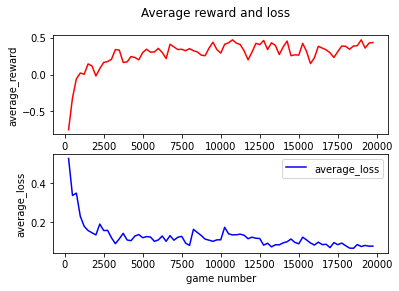

In [181]:
game_number = []
for i in range(80):
    game_number.append(250*i)
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Average reward and loss')
ax1.plot(game_number[1:],average_reward[1:],color='r',label='average_reward')
ax2.plot(game_number[1:],average_loss[1:], color="b",label="average_loss")

ax1.set(xlabel='game_number', ylabel='average_reward')
ax2.set(xlabel='game_number', ylabel='average_loss')

plt.xlabel("game number")
plt.legend()
plt.savefig('Ques12.png')
plt.savefig('Ques12.pdf')
plt.show()

# Question 13

In [197]:
BATCH_SIZE = 64
GAMMA = 0.99
BUFFER_SIZE = 10000
MIN_REPLAY_SIZE = 40
#EPS_START = 0.9
#EPS_END = 0.05
#EPS_DECAY = 200
TARGET_UPDATE_FREQ = 500

def epsilon_fxn(n,n_star):
    return np.maximum(0.1,0.8*(1-(n/n_star)))

class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        in_features = int(3*3*2)
        
        self.net = nn.Sequential(
            nn.Linear(in_features,128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,9)
        )

    def forward(self,x):
        return self.net((x.view(x.size(0), -1)))

    def act(self,obs):
        obs_t = torch.as_tensor(obs, dtype=torch.float32)
        q_values = self(obs_t.unsqueeze(0))

        max_q_index = torch.argmax(q_values,dim=1)[0]
        action = max_q_index.detach().item()
        return action


env = TictactoeEnv()

replay_buffer = deque(maxlen=BUFFER_SIZE)
rew_buffer = deque([0.], maxlen=100) #MAYBE 10 is better

episode_reward = 0.


policy_net = Network() #.to("cpu")
target_net = Network() #.to("cpu")
target_net.load_state_dict(policy_net.state_dict())

optimizer = torch.optim.Adam(policy_net.parameters(), lr=5e-4)

In [199]:
def initialise_replay_buffer():
    episode_reward = 0.
    replay_buffer = deque(maxlen=BUFFER_SIZE)
    env.reset()

    state_zero = env.observe()[0]

    for games in range(300):
        env.reset()

        if games%2 == 0:
            player1 = "X"
            player2 = "O"
            opt_player = OptimalPlayer(epsilon = 0.5, player = player2)
        if games%2 == 1:
            player1 = "O"
            player2 = "X"
            #change the state by *-1 when best player is X
            opt_player = OptimalPlayer(epsilon = 0.5, player = player2)
            grid, _, __ = env.observe()
            comp_move = opt_player.act(grid)
            env.step(comp_move)


        for rounds in range(5):

            #I play
            state_now = env.observe()[0]
            #selecting the best action considering the present state
            best_action1 = np.random.randint(0,9)
            
            ###If you can not take the action??
            if state_now[list_of_action[best_action1]] != 0:
                end = True
                rew = -1
                transition = (state_now, best_action1, rew, end, state_zero)
                replay_buffer.append(transition)
                episode_reward += rew
                rew_buffer.append(episode_reward)
                episode_reward = 0.
                break

            #make the move with that best action
            env.step(best_action1)

            #Now the computer plays (for a fair game ahaha)
            grid, _, __ = env.observe()
            
            if env.observe()[1] == True:
                rew = env.reward(player=player1)
                transition = (state_now, best_action1, rew, env.observe()[1], env.observe()[0])
                replay_buffer.append(transition)
                episode_reward += rew
                rew_buffer.append(episode_reward)
                episode_reward = 0.
                break
            
            
            comp_now = env.observe()[0]
            comp_move = opt_player.act(grid)
            env.step(comp_move)

            if env.observe()[1] == True:
                rew = env.reward(player=player1)
                transition = (state_now, best_action1, rew, env.observe()[1], env.observe()[0])
                replay_buffer.append(transition)
                episode_reward += rew
                rew_buffer.append(episode_reward)
                episode_reward = 0.
                break

            #Gather information about the state the game is in after the computer played
            future_state = env.observe()[0]
            
            _, end, winner = env.observe()
            rew = env.reward(player=player1)                    ##HAVE TO CHANGE ACCORDING TO THE PLAYER
            transition = (state_now, best_action1, rew, end, future_state)
            replay_buffer.append(transition)
            episode_reward += rew
            
    return replay_buffer
replay_buffer = initialise_replay_buffer()

In [200]:
##############MAIN TRAINING LOOP
#opt_player = OptimalPlayer(epsilon = 0.5, player = 'O')
M_opt = [[],[],[],[],[],[]]
M_rand = [[],[],[],[],[],[]]
#average_reward = [[],[],[],[],[],[]]
#average_loss = [[],[],[],[],[],[]]
n_star_list = [1, 1000, 5000, 10000, 20000, 40000]


#current_average_reward = 0
#current_training_loss = 0
env.reset()
obs = env.observe()[0]
zero_state = env.observe()[0]
step = 0
#epsilon = 0.3

for z in range(6):

    policy_net = Network() 
    target_net = Network() 
    target_net.load_state_dict(policy_net.state_dict())

    optimizer = torch.optim.Adam(policy_net.parameters(), lr=5e-4)
    repplay_buffer = initialise_replay_buffer()

    for games in range(20000):
        
        env.reset()
        epsilon_moving = epsilon_fxn(games,n_star_list[z])
        obs = env.observe()[0]
        #action = policy_net.act(make_state_for_input(obs))


        if games%2 == 0:
            player1 = "X"
            player2 = "O"
            opt_player = OptimalPlayer(epsilon = 0.5, player = player2)
        if games%2 == 1:
            player1 = "O"
            player2 = "X"
            #change the state by *-1 when best player is X
            opt_player = OptimalPlayer(epsilon = 0.5, player = player2)
            grid, _, __ = env.observe()
            comp_move = opt_player.act(grid)
            env.step(comp_move)

        #if games%250 == 0:
            #average_reward.append(current_average_reward/250)
            #current_average_reward = 0
            #print()
            #print(current_training_loss/250)
            #average_loss.append(current_training_loss/250)
            #current_training_loss = 0



        for rounds in range(5):
            
            #I play
            state_now = env.observe()[0]
            #selecting the best action considering the present state
            if epsilon_moving == 0.:
                best_action1 = policy_net.act(make_state_for_input(state_now))
            else:
                random_number = np.random.randint(0,10)
                if random_number >= epsilon_moving*10:
                    #print("best",epsilon_moving,random_number)
                    best_action1 = policy_net.act(make_state_for_input(state_now))
                else:
                    #print("random",epsilon_moving)
                    best_action1 = random_number
            #best_action1 = policy_net.act(make_state_for_input(state_now))
            
            ###If you can not take the action??
            if state_now[list_of_action[best_action1]] != 0:
                end = True
                rew = -1
                #current_average_reward += -1
                transition = (state_now, best_action1, rew, end, zero_state)
                replay_buffer.append(transition)
                episode_reward += rew
                rew_buffer.append(episode_reward)
                episode_reward = 0.
                break

            #make the move with that best action
            env.step(best_action1)

            #Now the computer plays (for a fair game ahaha)
            grid, _, __ = env.observe()
            
            if env.observe()[1] == True:
                rew = env.reward(player=player1)
                #current_average_reward += rew
                transition = (state_now, best_action1, rew, env.observe()[1], env.observe()[0])
                replay_buffer.append(transition)
                episode_reward += rew
                rew_buffer.append(episode_reward)
                episode_reward = 0.
                break
            
            #step += 1
            comp_now = env.observe()[0]
            comp_move = opt_player.act(grid)
            env.step(comp_move)

            if env.observe()[1] == True:
                rew = env.reward(player=player1)
                #current_average_reward += rew
                transition = (state_now, best_action1, rew, env.observe()[1], env.observe()[0])
                replay_buffer.append(transition)
                episode_reward += rew
                rew_buffer.append(episode_reward)
                episode_reward = 0.
                break

            #Gather information about the state the game is in after the computer played
            future_state = env.observe()[0]
            
            _, end, winner = env.observe()
            rew = env.reward(player=player1)                    ##HAVE TO CHANGE ACCORDING TO THE PLAYER
            transition = (state_now, best_action1, rew, end, future_state)
            replay_buffer.append(transition)
            episode_reward += rew
            




        ##START GRADIENT STEP
        transitions = random.sample(replay_buffer, BATCH_SIZE)

        obses = np.asarray([make_state_for_input(t[0]) for t in transitions])
        actions = np.asarray([t[1] for t in transitions])
        rew = np.asarray([t[2] for t in transitions])
        dones = np.asarray([t[3] for t in transitions])
        new_obses = np.asarray([make_state_for_input(t[4]) for t in transitions])

        obses_t = torch.as_tensor(obses, dtype=torch.float32)
        actions_t = torch.as_tensor(actions, dtype=torch.int64).unsqueeze(-1)
        rews_t = torch.as_tensor(rew, dtype=torch.float32).unsqueeze(-1)
        dones_t = torch.as_tensor(dones, dtype=torch.float32).unsqueeze(-1)
        new_obses_t = torch.as_tensor(new_obses, dtype=torch.float32)

        target_q_values = target_net(new_obses_t)
        
        max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
        
        targets = rews_t + GAMMA * (1 - dones_t) * max_target_q_values


        ###COMPUTE LOSS
        q_values = policy_net(obses_t)
        #q_values_max = q_values.max(dim=1, keepdim=True)[0]
        #print(actions_t.shape, q_values.shape)
        action_q_values = torch.gather(input=q_values, dim=1, index=actions_t)

        loss = nn.functional.smooth_l1_loss(action_q_values, targets)
        #current_training_loss += loss.item()

        ####GRADIENT STEP
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        ####UPDATE TARGET NETWORK
        if games % TARGET_UPDATE_FREQ == 0:
            target_net.load_state_dict(policy_net.state_dict())

        if games % 500 == 0:
            print("z",z)
            print("game",games)
            print("Avg_rew", np.mean(rew_buffer))
            print("Loss", loss)
            N_me, N_comp = number_wins(0.)
            print("M_opt",N_me,N_comp)
            M_opt[z].append((N_me-N_comp)/500)
            N_me, N_comp = number_wins(1.)
            print("M_rand",N_me,N_comp)
            M_rand[z].append((N_me-N_comp)/500)
        


z 0
game 0
Avg_rew -0.92
Loss tensor(0.1761, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 500
M_rand 0 500
z 0
game 500
Avg_rew -0.53
Loss tensor(0.0516, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 500
M_rand 228 225
z 0
game 1000
Avg_rew -0.23
Loss tensor(0.0407, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 500
M_rand 258 165
z 0
game 1500
Avg_rew -0.23
Loss tensor(0.0353, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 250
M_rand 323 100
z 0
game 2000
Avg_rew -0.05
Loss tensor(0.0478, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 208
M_rand 382 57
z 0
game 2500
Avg_rew -0.08
Loss tensor(0.0523, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 392
M_rand 415 46
z 0
game 3000
Avg_rew 0.1
Loss tensor(0.0507, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 155
M_rand 401 52
z 0
game 3500
Avg_rew 0.08
Loss tensor(0.0620, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 158
M_rand 400 55
z 0
game 4000
Avg_rew 0.13
Loss tensor(0.0744, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 150
M_rand 387 65
z 0
game 4500
Avg_rew 0.12
Loss tensor(0.05

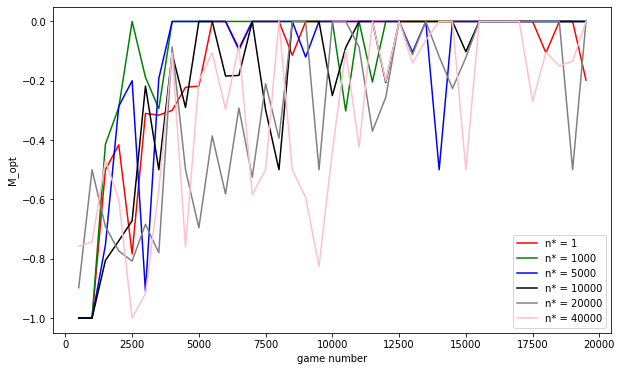

In [205]:
game_number = []
for i in range(40):
    game_number.append(500*i)
plt.rcParams["figure.figsize"] = (10,6)
plt.plot(game_number[1:], M_opt[0][1:],color='r',label='n* = 1')
plt.plot(game_number[1:], M_opt[1][1:],color='g',label='n* = 1000')
plt.plot(game_number[1:], M_opt[2][1:],color='b',label='n* = 5000')
plt.plot(game_number[1:], M_opt[3][1:],color='black',label='n* = 10000')
plt.plot(game_number[1:], M_opt[4][1:],color='gray',label='n* = 20000')
plt.plot(game_number[1:], M_opt[5][1:],color='pink',label='n* = 40000')
plt.ylabel("M_opt")
plt.xlabel("game number")
plt.legend()
plt.savefig('Ques13a.png')
plt.savefig('Ques13a.pdf')
plt.show()

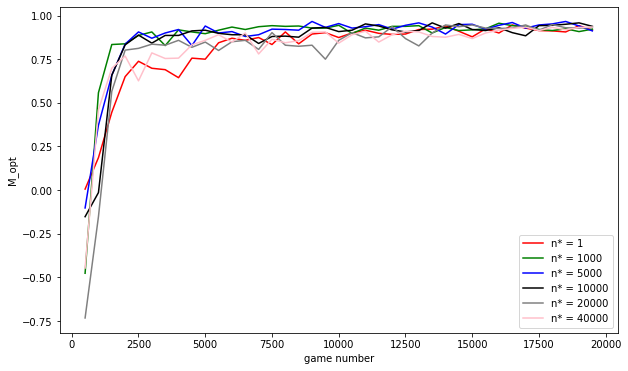

In [206]:
game_number = []
for i in range(40):
    game_number.append(500*i)
plt.rcParams["figure.figsize"] = (10,6)
plt.plot(game_number[1:], M_rand[0][1:],color='r',label='n* = 1')
plt.plot(game_number[1:], M_rand[1][1:],color='g',label='n* = 1000')
plt.plot(game_number[1:], M_rand[2][1:],color='b',label='n* = 5000')
plt.plot(game_number[1:], M_rand[3][1:],color='black',label='n* = 10000')
plt.plot(game_number[1:], M_rand[4][1:],color='gray',label='n* = 20000')
plt.plot(game_number[1:], M_rand[5][1:],color='pink',label='n* = 40000')
plt.ylabel("M_opt")
plt.xlabel("game number")
plt.legend()
plt.savefig('Ques13b.png')
plt.savefig('Ques13b.pdf')
plt.show()

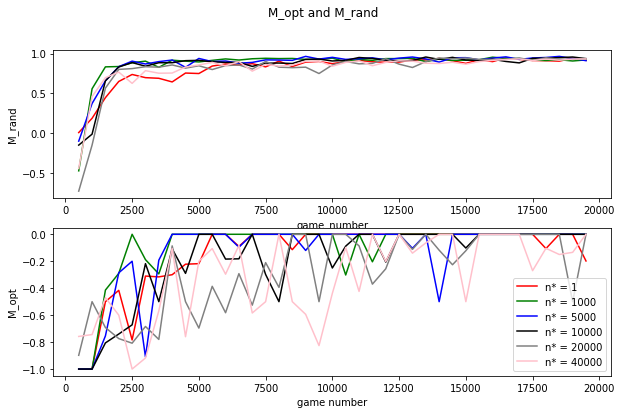

In [208]:
game_number = []
for i in range(40):
    game_number.append(500*i)

fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('M_opt and M_rand')

ax1.plot(game_number[1:], M_rand[0][1:],color='r',label='n* = 1')
ax1.plot(game_number[1:], M_rand[1][1:],color='g',label='n* = 1000')
ax1.plot(game_number[1:], M_rand[2][1:],color='b',label='n* = 5000')
ax1.plot(game_number[1:], M_rand[3][1:],color='black',label='n* = 10000')
ax1.plot(game_number[1:], M_rand[4][1:],color='gray',label='n* = 20000')
ax1.plot(game_number[1:], M_rand[5][1:],color='pink',label='n* = 40000')

ax2.plot(game_number[1:], M_opt[0][1:],color='r',label='n* = 1')
ax2.plot(game_number[1:], M_opt[1][1:],color='g',label='n* = 1000')
ax2.plot(game_number[1:], M_opt[2][1:],color='b',label='n* = 5000')
ax2.plot(game_number[1:], M_opt[3][1:],color='black',label='n* = 10000')
ax2.plot(game_number[1:], M_opt[4][1:],color='gray',label='n* = 20000')
ax2.plot(game_number[1:], M_opt[5][1:],color='pink',label='n* = 40000')


#ax1.plot(game_number[1:],average_reward[1:],color='r',label='average_reward')
#ax2.plot(game_number[1:],average_loss[1:], color="b",label="average_loss")

ax1.set(xlabel='game_number', ylabel='M_rand')
ax2.set(xlabel='game_number', ylabel='M_opt')

plt.xlabel("game number")
plt.legend()
plt.savefig('Ques13c.png')
plt.savefig('Ques13c.pdf')
plt.show()